## Quick data overview

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data
x = np.load('x.npy') # x coordinates discretization vector

Nx = x.shape[0]
print("Num of discretization of x coordinates: ",Nx)

u0_train = np.load('u0_train_data.npy')
u0_test  = np.load('u0_test_data.npy')

Ntrain = u0_train.shape[0]
Ntest  = u0_test.shape[0]
print("Trainning data size:", Ntrain)
print("Testing data size:", Ntest)

u_train = np.load('u_train_data.npy')
u_test  = np.load('u_test_data.npy')

Num of discretization of x coordinates:  100
Trainning data size: 2000
Testing data size: 2000


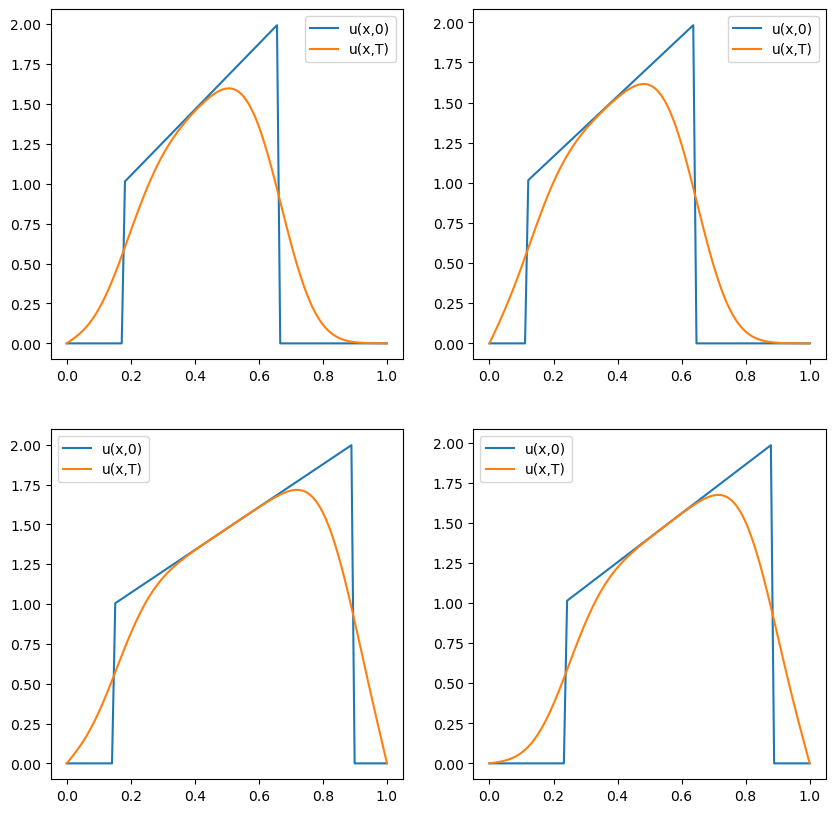

In [3]:
# Plotting a few training samples
fig,axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()
for s in range (4):
    axs[s].plot(x,u0_train[s],label='u(x,0)')
    axs[s].plot(x,u_train[s],label='u(x,T)')
    axs[s].legend()
# plt.savefig('result/samples.png',bbox_inches='tight')

## Score-Based Conditional Diffusion Model

### DM Architechture

In [4]:
#!/usr/bin/env python
# coding: utf-8

# # ==========================================================================================
# # Generic Conditional Score-Based Diffusion Model Module
# #
# # Description:
# # This script provides a self-contained, problem-agnostic implementation of a
# # conditional score-based diffusion model. It is designed to solve inverse problems
# # by learning the conditional score function s(x_t, y, t) directly from paired data (x, y),
# # as described in "Unifying and extending Diffusion Models through PDEs for solving
# # Inverse Problems" (arXiv:2504.07437).
# # ==========================================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau 
from torch.utils.data import DataLoader, Dataset
import numpy as np
import functools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # this is for notebook and terminal
# from tqdm import tqdm # Use standard tqdm if notebook tqdm not available
from livelossplot import PlotLosses
import copy

class SimpleScaler:
    """A simple scaler that standardizes data to zero mean and unit variance."""
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, data):
        self.mean_ = np.mean(data, axis=0)
        self.scale_ = np.std(data, axis=0)
        # Handle cases where std dev is zero to avoid division by zero
        self.scale_[self.scale_ == 0] = 1.0
        return self

    def transform(self, data):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler has not been fitted yet.")
        return (data - self.mean_) / self.scale_

    def inverse_transform(self, data):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler has not been fitted yet.")
        return data * self.scale_ + self.mean_

    def get_state(self):
        return {'mean_': self.mean_, 'scale_': self.scale_}

    def load_state(self, state):
        self.mean_ = state['mean_']
        self.scale_ = state['scale_']
        return self
        
# --- 1. SDE and Time Embedding Definition (Problem-Agnostic) ---

class GaussianFourierProjection(nn.Module):
    """
    Encodes scalar time-steps into a high-dimensional feature vector
    using a set of fixed (non-trainable) random Fourier features.
    """
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, t):
        t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

def marginal_prob_std_fn(t, sigma):
    """
    Computes the standard deviation of p(x_t|x_0) for the VE-SDE.
    This corresponds to sigma_t in the notation p(x_t|x_0) = N(x_t; alpha_t*x_0, sigma_t^2*I).
    """
    t = torch.as_tensor(t)
    return torch.sqrt((sigma**(2 * t) - 1.) / (2. * np.log(sigma)))

def diffusion_coeff_fn(t, sigma):
    """Computes the diffusion coefficient g(t) for the VE-SDE."""
    t = torch.as_tensor(t)
    return sigma**t

# --- 2. Conditional Score Network (Problem-Agnostic) ---

class ConditionalScoreNet(nn.Module):
    """
    A time-dependent, conditional score-based model.
    It learns the score of the conditional distribution p_t(x|y), denoted as s(x, y, t).
    """
    def __init__(self, marginal_prob_std, x_dim, y_dim, hidden_depth=3, embed_dim=256):
        super().__init__()
        self.marginal_prob_std = marginal_prob_std
        
        # Time and condition embedding layers
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        # A simple linear layer to embed the condition y
        self.condition_embed = nn.Linear(y_dim, embed_dim)
        
        # Main network layers
        self.input_layer = nn.Linear(x_dim, embed_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(embed_dim, embed_dim) for _ in range(hidden_depth)
        ])
        self.output_layer = nn.Linear(embed_dim, x_dim)
        
        self.act = nn.LeakyReLU(0.01)

    def forward(self, x, y, t):
        # 1. Generate embeddings for time and condition
        t_embedding = self.act(self.time_embed(t))
        y_embedding = self.act(self.condition_embed(y))
        
        # 2. Combine embeddings (simple addition)
        combined_embedding = t_embedding + y_embedding
        
        # 3. Process x through the network, modulated by the combined embedding
        h = self.act(self.input_layer(x))
        for layer in self.hidden_layers:
            # Add embedding and apply residual connection
            h = self.act(layer(h) + combined_embedding)
        
        out = self.output_layer(h)
        
        # 4. Scale output by the marginal standard deviation (a key part of the design)
        out = out / self.marginal_prob_std(t)[:, None]
        return out

class ConditionalConv1DScoreNet(nn.Module):
    """
    A time-dependent, conditional score-based model using a 1D U-Net architecture.
    It is specifically designed for function-like data where spatial correlation is important.
    It learns the score s(x, y, t).
    """
    def __init__(self, marginal_prob_std, x_dim, y_dim, hidden_depth=3, embed_dim=256):
        super().__init__()
        self.marginal_prob_std = marginal_prob_std
        
        # Time and condition embedding layers
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        self.condition_embed = nn.Linear(y_dim, embed_dim)
        self.act = nn.LeakyReLU(0.01)

        # 1D U-Net Backbone
        # Encoder path
        kernel_size = 3
        padding = (kernel_size - 1) // 2 # This is robust, calculates to 1
        self.conv_in = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=kernel_size, padding=padding) # Note: Input channel is now 1 (only x_t), as y is handled by embedding.
        self.conv1 = nn.Conv1d(32, 64, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=kernel_size, padding=padding)
        
        # Bottleneck layer for time embedding injection
        self.embedding_injector = nn.Linear(embed_dim, 128)

        # Decoder path with skip connections
        self.deconv1 = nn.Conv1d(128 + 64, 64, kernel_size=kernel_size, padding=padding)
        self.deconv2 = nn.Conv1d(64 + 32, 32, kernel_size=kernel_size, padding=padding)
        self.conv_out = nn.Conv1d(32 , 1, kernel_size=kernel_size, padding=padding)
        
    def forward(self, x, y, t):
        # Reshape inputs to (Batch, Channels, Length) for Conv1d
        x = x.unsqueeze(1)
        # y is a vector, no need to unsqueeze, it will be used for embedding.

        # --- FIX: Correctly generate and combine embeddings for BOTH time and condition ---
        t_embedding = self.act(self.time_embed(t))
        y_embedding = self.act(self.condition_embed(y))
        combined_embedding = t_embedding + y_embedding
        
        # --- 1D U-Net Dataflow ---
        # Encoder
        # Note: Input is now just x, not the concatenation.
        h1 = self.act(self.conv_in(x))      # -> (B, 32, Length)
        h2 = self.act(self.conv1(h1))       # -> (B, 64, Length)
        h3 = self.act(self.conv2(h2))       # -> (B, 128, Length)

        # Inject COMBINED embedding at the bottleneck
        emb = self.embedding_injector(combined_embedding).unsqueeze(-1)
        h3_inj = h3 + emb # Broadcasts the embedding across the spatial dimension

        # Decoder with Skip Connections
        h_dec2_in = torch.cat([h3_inj, h2], dim=1)
        h_dec2 = self.act(self.deconv1(h_dec2_in))
        
        h_dec1_in = torch.cat([h_dec2, h1], dim=1)
        h_dec1 = self.act(self.deconv2(h_dec1_in))
        
        # The final input for the output convolution should not include the original x
        # as it's already part of the skip connection from h1
        out = self.conv_out(h_dec1) # Use h_dec1 directly
        
        # Reshape output back to (Batch, Length)
        out = out.squeeze(1)
        
        # Scale output by the marginal standard deviation
        out = out / self.marginal_prob_std(t)[:, None]
        return out

# --- 3. Loss Function (Problem-Agnostic) ---

def conditional_loss_fn(model, x, y, marginal_prob_std, eps=1e-5):
    """
    The loss function for training the conditional score model.
    Corresponds to the denoising score matching loss for p(x|y).
    with weighting to prioritize smaller noise levels.
    """
    # Sample random time steps
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    
    # Sample noise and perturb data
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    
    # Get model's score prediction
    score = model(perturbed_x, y, random_t)
    
    # # Calculate loss
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))

    # Calculate the loss for each original sample.
    # loss_per_sample = torch.sum((score * std[:, None] + z)**2, dim=1)
    
    # # Define weights (using 1/std^2 here, other weights can also be tried)
    # # This weight amplifies the loss when t is small (std is small)
    # loss_weights = 1.0 / (std**2)
    
    # # Apply weights and calculate the mean.
    # loss = torch.mean(loss_weights * loss_per_sample)
    return loss

# --- 4. Training Infrastructure (Problem-Agnostic) ---

class PairedDataset(Dataset):
    """A dataset for (x, y) pairs."""
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def train_conditional_model(
    score_model,
    # Data
    x_train_data, y_train_data,
    x_test_data, y_test_data,
    # Training params
    lr=1e-4, batch_size=32, n_epochs=100,
    # Validation params
    eval_freq=25,
    num_eval_samples=50,
    num_gen_samples=10,
    # Control flags
    live_plot=True,
    # Sampler and other components
    sampler_fn=None,
    sampler_params=None,
    x_scaler=None,
    device='cpu'
):
    """
    Trains the model for the full duration, live-plots metrics, saves the best model
    based on generation_MSE, and returns the complete metric history.
    """
    # Setup DataLoaders for both training and validation
    train_dataset = PairedDataset(x_train_data.to(device), y_train_data.to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    test_dataset = PairedDataset(x_test_data.to(device), y_test_data.to(device))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    optimizer = Adam(score_model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs) # Using a learning rate scheduler helps with better convergence in the later stages of training.
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=400)
    
    # Use groups to plot losses and MSE on different axes, only initialize PlotLosses when needed.
    liveloss = PlotLosses(groups={'Log Loss': ['train_loss', 'val_loss'], 'Generation MSE': ['mse']}) if live_plot else None
    # --- History lists to store all metrics ---
    history = {'train_loss': [], 'val_loss': [], 'mse': []}
    best_mse = float('inf')
    best_model_state = None
    
    tqdm_epoch = tqdm(range(n_epochs), desc="Training Epochs", position=0, leave=True)
    for epoch in tqdm_epoch:
        # --- Training Phase ---
        score_model.train()
        train_loss = 0.
        num_items = 0
        for x_batch, y_batch in train_loader:
            loss = conditional_loss_fn(score_model, x_batch, y_batch, score_model.marginal_prob_std)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.shape[0]
            num_items += x_batch.shape[0]
        avg_train_loss = train_loss / num_items
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase ---
        score_model.eval()
        val_loss = 0.
        num_items_val = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                loss = conditional_loss_fn(score_model, x_batch, y_batch, score_model.marginal_prob_std)
                val_loss += loss.item() * x_batch.shape[0]
                num_items_val += x_batch.shape[0]
        avg_val_loss = val_loss / num_items_val
        history['val_loss'].append(avg_val_loss)

        
        # --- Generation MSE Phase (run periodically to save time) ---
        avg_mse = np.nan # Default to NaN if not calculated this epoch
        if (epoch + 1) % eval_freq == 0 or (epoch == n_epochs - 1): # must compare at the last epoch
            with torch.no_grad():
                # (The generation logic is the same as below)
                total_mse = 0.
                # Randomly select indices from the test set for evaluation
                n_test = len(x_test_data)
                eval_indices = np.random.choice(n_test, num_eval_samples, replace=False)
                for i in eval_indices:
                    y_cond_scaled = y_test_data[i].unsqueeze(0)
                    x_true_unscaled_np = x_scaler.inverse_transform(x_test_data[i].cpu().numpy().reshape(1, -1)).flatten()
                    gen_samples_scaled = sampler_fn(score_model=score_model, y_cond=y_cond_scaled, batch_size=num_gen_samples, **sampler_params)
                    gen_samples_unscaled = x_scaler.inverse_transform(gen_samples_scaled.cpu().numpy())
                    gen_mean = np.mean(gen_samples_unscaled, axis=0)
                    total_mse += np.mean((gen_mean - x_true_unscaled_np)**2)
                avg_mse = total_mse / num_eval_samples

                if avg_mse < best_mse:
                    best_mse = avg_mse
                    best_model_state = copy.deepcopy(score_model.state_dict())
        
        history['mse'].append(avg_mse) # Append MSE or NaN to history
        
        if liveloss:
            logs = {'train_loss': avg_train_loss, 'val_loss': avg_val_loss}
            if not np.isnan(avg_mse): # Only add mse if it was calculated
                logs['mse'] = avg_mse
            liveloss.update(logs)
            # Only start sending (drawing) the plot AFTER the first MSE has been calculated.
            # This ensures the 'mse' key exists in the logger's history.
            if (epoch + 1) >= eval_freq:
                liveloss.send()
        else: # Print losses manually if live_plot is disabled
            msg = f"[Epoch {epoch+1:03d}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}"
            if not np.isnan(avg_mse):
                msg += f" | MSE: {avg_mse:.6f}"
            print(msg)
                
        # Update learning rate
        scheduler.step()
        # scheduler.step(avg_val_loss)  # For ReduceLROnPlateau; if using CosineAnnealingLR, use scheduler.step()


    if best_model_state:
        print(f"\nLoading best model with final generation_MSE: {best_mse:.4f}")
        score_model.load_state_dict(best_model_state)

    return score_model, history

# --- 5. Sampler (Problem-Agnostic) ---

def conditional_sampler(
    score_model,
    marginal_prob_std,
    diffusion_coeff,
    y_cond,
    batch_size,
    x_dim,
    num_steps=500,
    device='cpu',
    eps=1e-3
):
    """
    Generates samples from the conditional distribution p(x|y) using the trained score model.
    Implements the reverse-time SDE sampler (Euler-Maruyama method).
    """
    score_model.eval()
    t_init = torch.ones(batch_size, device=device)
    
    # Start from pure noise
    init_x = torch.randn(batch_size, x_dim, device=device) * marginal_prob_std(t_init)[:, None]
    
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    
    x = init_x
    y_cond_batch = y_cond.repeat(batch_size, 1).to(device)

    with torch.no_grad():
        # for time_step in tqdm(time_steps, desc="Conditional Sampling"):
        # for time_step in tqdm(time_steps, desc="Conditional Sampling", disable=not show_progress):
        sampler_iterator = tqdm(time_steps, desc="Conditional Sampling", position=1, leave=False)
        for time_step in sampler_iterator:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            
            # The core change: directly use the conditional score model
            score = score_model(x, y_cond_batch, batch_time_step)
            
            # Euler-Maruyama update
            mean_x = x + (g**2)[:, None] * score * step_size
            noise = torch.randn_like(x)
            x = mean_x + g[:, None] * torch.sqrt(step_size) * noise
            
    return mean_x



### Training DM

In [5]:
# ==============================================================================
# PART 2: Main Script for Training the Conditional Diffusion Model
#
# Workflow:
# 1. Configuration: Set up all hyperparameters and flags.
# 2. Data Preparation: Load, filter, split, and normalize the dataset.
# 3. Model Initialization: Define the model and SDE functions based on configs.
# 4. Training Execution: Run the training process.
# 5. Results & Saving: Save the best model checkpoint and plot metrics.
# ==============================================================================


# --- 2.1 Configuration ---
# File Paths
MODEL_SAVE_PATH = 'best1_score_model_checkpoint.pth'

# Data Splitting
validation_split = 0.2
random_seed = 42

# SDE Hyperparameters
SIGMA_VE = 25.0

# Model Hyperparameters
EMBED_DIM, HIDDEN_DEPTH = 1024, 4

# Training Hyperparameters
N_EPOCHS, BATCH_SIZE, LEARNING_RATE = 50000, 256, 1e-4

# Sampler Configuration
SAMPLER_NUM_STEPS = 500

NOISE_LEVEL = 0.20  # relative 5% componentwise

# --- 2.2 Setup Environment and Load Data ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

x_coords = np.load('x.npy')
u0_train_np_raw = np.load('u0_train_data.npy')
u_train_np_raw = np.load('u_train_data.npy')
u0_test_np_raw = np.load('u0_test_data.npy')
u_test_np_raw = np.load('u_test_data.npy')

# --- 2.3 Filter out zero-valued ground truth samples ---
print("\nFiltering dataset to keep only non-zero ground truth samples...")

# Filter training data
train_non_zero_indices = [idx for idx, sample in enumerate(u0_train_np_raw) if np.max(np.abs(sample)) > 1e-6]
u0_train_full_np = u0_train_np_raw[train_non_zero_indices]
u_train_full_np = u_train_np_raw[train_non_zero_indices]

# Filter testing data
test_non_zero_indices = [idx for idx, sample in enumerate(u0_test_np_raw) if np.max(np.abs(sample)) > 1e-6]
u0_test_np = u0_test_np_raw[test_non_zero_indices]
u_test_np = u_test_np_raw[test_non_zero_indices]

print(f"Original training size: {len(u0_train_np_raw)}, Filtered training size: {len(u0_train_full_np)}")
print(f"Original testing size: {len(u0_test_np_raw)}, Filtered testing size: {len(u0_test_np)}")

# ---Add Gaussian noise to each dimension 

# Compute std per dimension over all training samples (shape: (num_dims,))
y_train_std = np.std(u_train_full_np, axis=0)  # (num_dims,)
y_test_std = np.std(u_test_np, axis=0)  # (num_dims,)

# Add noise to training outputs only 
u_train_full_np = u_train_full_np + np.random.randn(*u_train_full_np.shape) * (NOISE_LEVEL * y_train_std) # *** uncomment to add noise
u_test_np = u_test_np + np.random.randn(*u_test_np.shape) * (NOISE_LEVEL * y_test_std)

# --- 2.4 Split the full training data into train and validation sets ---
print("\nSplitting training data into training and validation sets...")
# Create and shuffle indices
np.random.seed(random_seed)
num_train_full = len(u0_train_full_np)
indices = np.random.permutation(num_train_full)

# Determine the split point
split_idx = int(num_train_full * (1 - validation_split))

# Split indices
train_indices, val_indices = indices[:split_idx], indices[split_idx:]

# Create the data splits using the indices
u0_train_np, u0_val_np = u0_train_full_np[train_indices], u0_train_full_np[val_indices]
u_train_np, u_val_np = u_train_full_np[train_indices], u_train_full_np[val_indices]
print(f"Final training size: {len(u0_train_np)}, Validation size: {len(u0_val_np)}, Test size: {len(u0_test_np)}")

# --- 2.5 Get Data Dimensions ---
X_DIM, Y_DIM = u0_train_np.shape[1], u_train_np.shape[1]
print(f"\nProblem Dimensions: X_DIM = {X_DIM}, Y_DIM = {Y_DIM}")

# --- 2.6 Data Normalization and Tensor Conversion ---
print("\nNormalizing data...")
# Initialize and fit scalers ONLY on training data
x_scaler = SimpleScaler().fit(u0_train_np) 
y_scaler = SimpleScaler().fit(u_train_np)  

x_train_tensor = torch.from_numpy(x_scaler.transform(u0_train_np)).float()
y_train_tensor = torch.from_numpy(y_scaler.transform(u_train_np)).float()
x_val_tensor = torch.from_numpy(x_scaler.transform(u0_val_np)).float()
y_val_tensor = torch.from_numpy(y_scaler.transform(u_val_np)).float()

# --- 2.7 Initialize Model, SDE, and Sampler ---
# Define SDE functions
marginal_prob_std = functools.partial(marginal_prob_std_fn, sigma=SIGMA_VE)
diffusion_coeff = functools.partial(diffusion_coeff_fn, sigma=SIGMA_VE)

# Consolidate hyperparameter dictionaries for saving
model_hyperparams = {
    'x_dim': X_DIM, 'y_dim': Y_DIM,
    'embed_dim': EMBED_DIM, 'hidden_depth': HIDDEN_DEPTH
}
sde_hyperparams = {'sigma': SIGMA_VE}
sampler_params = { # Configure the sampler
    'marginal_prob_std': marginal_prob_std,
    'diffusion_coeff': diffusion_coeff,
    'x_dim': X_DIM,
    'num_steps': SAMPLER_NUM_STEPS,
    'device': device
}

# Initialize the Score Model
score_model = ConditionalScoreNet(
    marginal_prob_std, X_DIM, Y_DIM, HIDDEN_DEPTH, EMBED_DIM
).to(device)
# score_model = ConditionalConv1DScoreNet(
#     marginal_prob_std, X_DIM, Y_DIM, embed_dim=EMBED_DIM
# ).to(device)

# --- 2.8 Training Execution ---
print(f"\nStarting training for a new model with {sum(p.numel() for p in score_model.parameters())} parameters...")
score_model, history = train_conditional_model(
    score_model,
    x_train_data=x_train_tensor, y_train_data=y_train_tensor,
    x_test_data=x_val_tensor, y_test_data=y_val_tensor, # Use validation set for model selection
    lr=LEARNING_RATE, batch_size=BATCH_SIZE, n_epochs=N_EPOCHS,
    eval_freq=N_EPOCHS//8,
    live_plot=False, # Setting to False disables plotting and speeds up training.
    sampler_fn=conditional_sampler,
    sampler_params=sampler_params,
    x_scaler=x_scaler,
    device=device
)
print("Training finished.")

# --- 2.9 Save the Best Model and Plot Metrics ---
# --- Save the entire checkpoint ---
print(f"Saving the best model checkpoint to {MODEL_SAVE_PATH}...")
checkpoint = {
    'model_state_dict': score_model.state_dict(),
    'model_hyperparams': model_hyperparams,
    'sde_hyperparams': sde_hyperparams,
    'scaler_states': {
        'x_scaler': x_scaler.get_state(),
        'y_scaler': y_scaler.get_state()
    },
    'training_history': history
}
torch.save(checkpoint, MODEL_SAVE_PATH)
print("Checkpoint saved.")

fig_loss, ax1 = plt.subplots(figsize=(12, 7))

# Plotting training and validation loss on the first y-axis
ax1.plot(history['train_loss'], 'b-', label='Training Loss')
ax1.plot(history['val_loss'], 'c--', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score Matching Loss (log scale)', color='b')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, linestyle=':')

# Creating a second y-axis for the generation MSE
ax2 = ax1.twinx()
ax2.plot(history['mse'], 'r.-', label='Generation MSE')
ax2.set_ylabel('Generation MSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig_loss.suptitle('Training and Validation Metrics Over Epochs')
# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_loss.savefig('final_loss_curve1.png')
print("Metrics curve saved to 'final_loss_curve1.png'.")

Using device: cpu

Filtering dataset to keep only non-zero ground truth samples...
Original training size: 2000, Filtered training size: 2000
Original testing size: 2000, Filtered testing size: 100

Splitting training data into training and validation sets...
Final training size: 1600, Validation size: 400, Test size: 100

Problem Dimensions: X_DIM = 100, Y_DIM = 100

Normalizing data...

Starting training for a new model with 5557860 parameters...


Training Epochs:   0%|          | 0/50000 [00:00<?, ?it/s]

[Epoch 001] Train Loss: 105.519538 | Val Loss: 103.382267
[Epoch 002] Train Loss: 102.472214 | Val Loss: 100.570580
[Epoch 003] Train Loss: 101.252258 | Val Loss: 100.637545
[Epoch 004] Train Loss: 99.049813 | Val Loss: 98.875910
[Epoch 005] Train Loss: 98.116871 | Val Loss: 95.696466
[Epoch 006] Train Loss: 96.616717 | Val Loss: 96.095332
[Epoch 007] Train Loss: 94.668872 | Val Loss: 93.241983
[Epoch 008] Train Loss: 91.631298 | Val Loss: 89.358437
[Epoch 009] Train Loss: 88.161861 | Val Loss: 85.341927
[Epoch 010] Train Loss: 83.769228 | Val Loss: 81.285225
[Epoch 011] Train Loss: 79.711374 | Val Loss: 77.131063
[Epoch 012] Train Loss: 76.238514 | Val Loss: 74.224293
[Epoch 013] Train Loss: 72.747482 | Val Loss: 72.160988
[Epoch 014] Train Loss: 71.669350 | Val Loss: 70.665994
[Epoch 015] Train Loss: 68.034067 | Val Loss: 66.217334
[Epoch 016] Train Loss: 66.946871 | Val Loss: 64.507740
[Epoch 017] Train Loss: 63.164782 | Val Loss: 61.913643
[Epoch 018] Train Loss: 62.693971 | Val Lo

KeyboardInterrupt: 

### Inference and visualizations for this run

In [ ]:
# --- 2.10 Final, Unbiased Evaluation on the TRUE Test Set ---
print("\nPerforming final, unbiased evaluation on the held-out test set...")
NUM_TEST_SAMPLES_TO_PLOT = 4
NUM_POSTERIOR_SAMPLES = 100

fig_results, axes = plt.subplots(NUM_TEST_SAMPLES_TO_PLOT, 1, figsize=(10, 5 * NUM_TEST_SAMPLES_TO_PLOT), sharex=True)
if NUM_TEST_SAMPLES_TO_PLOT == 1: axes = [axes]

plot_indices = np.random.choice(len(u0_test_np), NUM_TEST_SAMPLES_TO_PLOT, replace=False)

for i, ax in zip(plot_indices, axes):
    # Now we use the true test data for plotting
    y_condition_np = u_test_np[i]
    x_ground_truth_np = u0_test_np[i]
    
    y_condition_scaled_np = y_scaler.transform(y_condition_np.reshape(1, -1))
    y_condition_tensor = torch.from_numpy(y_condition_scaled_np).float().to(device)
    
    posterior_samples_scaled = conditional_sampler(
        score_model, marginal_prob_std, diffusion_coeff, y_condition_tensor,
        NUM_POSTERIOR_SAMPLES, X_DIM, num_steps=2000, device=device # Use more steps for final quality
    )
    
    posterior_samples_np = x_scaler.inverse_transform(posterior_samples_scaled.cpu().numpy())
    posterior_mean = np.mean(posterior_samples_np, axis=0)
    posterior_std = np.std(posterior_samples_np, axis=0)
    
    # ... (Plotting logic remains the same)
    ax.plot(x_coords, y_condition_np, 'k:', linewidth=2, label='$u(x,T)$ (Given Condition)')
    ax.plot(x_coords, x_ground_truth_np, 'g-', linewidth=2, label='$u(x,0)$ (Ground Truth)')
    ax.plot(x_coords, posterior_mean, 'r--', linewidth=2, label='Posterior Mean Prediction')
    ax.fill_between(
        x_coords, posterior_mean - 2 * posterior_std, posterior_mean + 2 * posterior_std,
        color='r', alpha=0.2, label='Posterior Uncertainty ($\pm 2\sigma$)'
    )
    ax.set_title(f"True Test Sample (Original Index #{test_non_zero_indices[i]})")
    ax.set_ylabel("u(x)")
    ax.legend()
    ax.grid(True, linestyle='--')

axes[-1].set_xlabel("x")
plt.tight_layout()
fig_results.savefig('final_unbiased_test_results1.png')
print("Inference finished. Final results plot saved to 'final_unbiased_test_results.png'.")
plt.show()

### Inference from loaded model(checkpoint)

Using device: cpu for inference.
Loading model and configuration from /Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noiseless_Y/epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/best_score_model_checkpoint.pth...
SDE functions recreated.
Data scalers recreated.
Model architecture recreated and weights loaded successfully.

Performing inference on the filtered test set of size 100...


Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Inference finished. Final results plot saved to 'final_unbiased_test_results.png'.


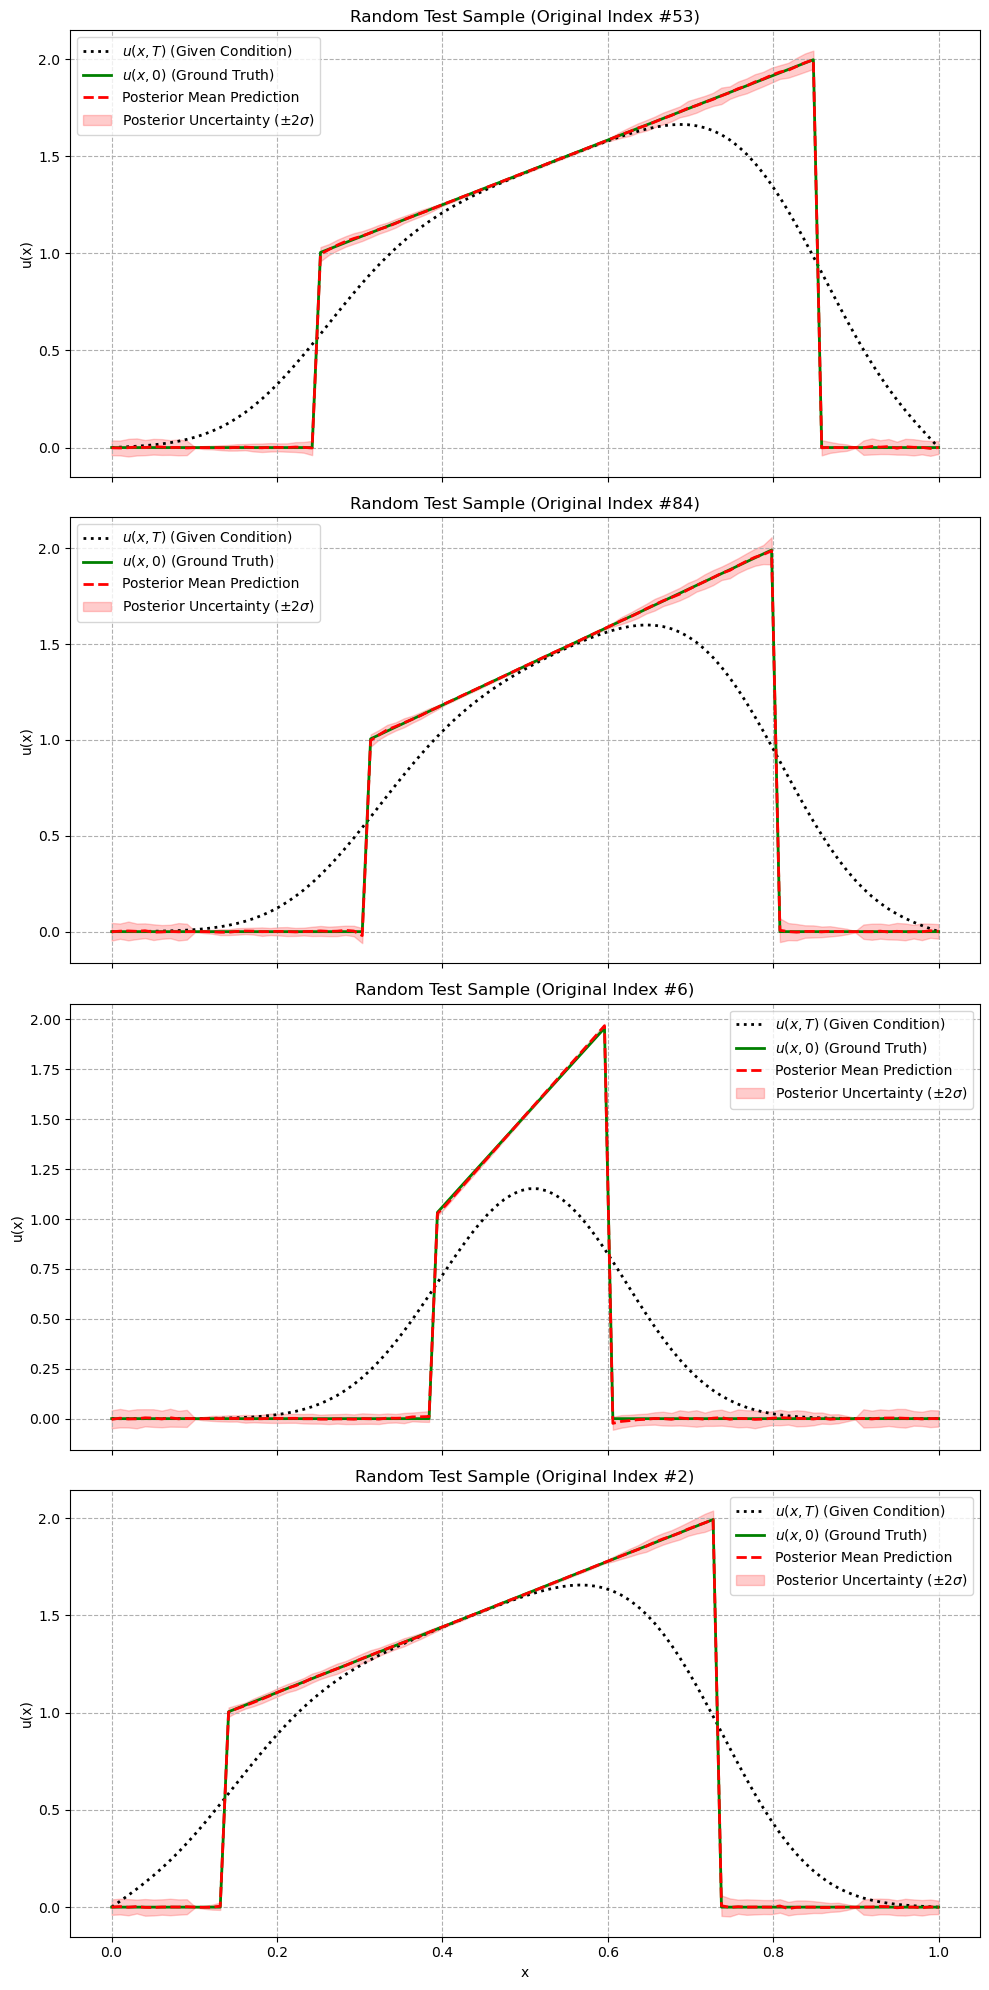

In [6]:
# ==========================================================================================
# PART 3: Standalone Inference and Visualization Cell
# ==========================================================================================

# --- 3.1 Setup Environment ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_SAVE_PATH = '/Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noiseless_Y/epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/best_score_model_checkpoint.pth'

# MODEL_SAVE_PATH = 'results/epoch40000_batch1024_CNN_TooSmooth/best_score_model_checkpoint.pth'
print(f"Using device: {device} for inference.")

# --- 3.2 Load the Complete Checkpoint ---
print(f"Loading model and configuration from {MODEL_SAVE_PATH}...")
try:
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=False)
except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {MODEL_SAVE_PATH}. Please run the training cell first.")
    exit()

# --- 3.3 Recreate All Components from the Checkpoint ---

# a) Recreate SDE functions from saved hyperparameters
loaded_sde_params = checkpoint['sde_hyperparams']
marginal_prob_std = functools.partial(marginal_prob_std_fn, **loaded_sde_params)
diffusion_coeff = functools.partial(diffusion_coeff_fn, **loaded_sde_params)
print("SDE functions recreated.")

# b) Recreate and load states for data scalers
loaded_scaler_states = checkpoint['scaler_states']
x_scaler = SimpleScaler().load_state(loaded_scaler_states['x_scaler'])
y_scaler = SimpleScaler().load_state(loaded_scaler_states['y_scaler'])
print("Data scalers recreated.")

# c) Recreate Model and load weights
loaded_model_params = checkpoint['model_hyperparams']
# !!! make sure the NN architecture is consistent !!!
inference_model = ConditionalScoreNet(marginal_prob_std, **loaded_model_params).to(device)
# inference_model = ConditionalConv1DScoreNet(marginal_prob_std, **loaded_model_params).to(device)
inference_model.load_state_dict(checkpoint['model_state_dict'])
inference_model.eval() # Set model to evaluation mode
print("Model architecture recreated and weights loaded successfully.")

# --- 3.4 Perform Final, Unbiased Evaluation on the TRUE Test Set ---

# Load the necessary raw data for inference and plotting
x_coords = np.load('x.npy')
u0_test_np_raw = np.load('u0_test_data.npy')
u_test_np_raw = np.load('u_test_data.npy')

# Filter the test data just as in training to ensure consistency
test_non_zero_indices = [idx for idx, s in enumerate(u0_test_np_raw) if np.max(np.abs(s)) > 1e-6]
u0_test_np = u0_test_np_raw[test_non_zero_indices]
u_test_np = u_test_np_raw[test_non_zero_indices]

print(f"\nPerforming inference on the filtered test set of size {len(u0_test_np)}...")
NUM_TEST_SAMPLES_TO_PLOT = 4
NUM_POSTERIOR_SAMPLES = 100

fig_results, axes = plt.subplots(NUM_TEST_SAMPLES_TO_PLOT, 1, figsize=(10, 5 * NUM_TEST_SAMPLES_TO_PLOT), sharex=True)
if NUM_TEST_SAMPLES_TO_PLOT == 1: axes = [axes]

# Define sampler_params for the inference call
sampler_params = {
    'marginal_prob_std': marginal_prob_std,
    'diffusion_coeff': diffusion_coeff,
    'x_dim': loaded_model_params['x_dim'],
    'num_steps': 2000, # Using more steps for final high-quality results
    'device': device
}

# Randomly select indices from the filtered test set for plotting
plot_indices = np.random.choice(len(u0_test_np), NUM_TEST_SAMPLES_TO_PLOT, replace=False)

for i, ax in zip(plot_indices, axes):
    y_condition_np = u_test_np[i]
    x_ground_truth_np = u0_test_np[i]
    
    # Scale the condition using the loaded scaler
    y_condition_scaled_np = y_scaler.transform(y_condition_np.reshape(1, -1))
    y_condition_tensor = torch.from_numpy(y_condition_scaled_np).float().to(device)
    
    # Generate samples using the loaded model
    posterior_samples_scaled = conditional_sampler(
        inference_model,
        **sampler_params,
        y_cond=y_condition_tensor,
        batch_size=NUM_POSTERIOR_SAMPLES
    )
    
    # Inverse-transform the generated samples to the original data scale
    posterior_samples_np = x_scaler.inverse_transform(posterior_samples_scaled.cpu().numpy())
    
    # Calculate statistics and plot
    posterior_mean = np.mean(posterior_samples_np, axis=0)
    posterior_std = np.std(posterior_samples_np, axis=0)
    
    ax.plot(x_coords, y_condition_np, 'k:', linewidth=2, label='$u(x,T)$ (Given Condition)')
    ax.plot(x_coords, x_ground_truth_np, 'g-', linewidth=2, label='$u(x,0)$ (Ground Truth)')
    ax.plot(x_coords, posterior_mean, 'r--', linewidth=2, label='Posterior Mean Prediction')
    ax.fill_between(
        x_coords, posterior_mean - 2 * posterior_std, posterior_mean + 2 * posterior_std,
        color='r', alpha=0.2, label='Posterior Uncertainty ($\pm 2\sigma$)'
    )
    ax.set_title(f"Random Test Sample (Original Index #{test_non_zero_indices[i]})")
    ax.set_ylabel("u(x)")
    ax.legend()
    ax.grid(True, linestyle='--')

axes[-1].set_xlabel("x")
plt.tight_layout()
fig_results.savefig('final_unbiased_test_results.png')
print("Inference finished. Final results plot saved to 'final_unbiased_test_results.png'.")
plt.show()

In [16]:
# NEW INFERENCE SECTION

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import functools

# ------------------------
# USER SETTINGS
# ------------------------
MODEL_SAVE_PATH = '/Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noiseless_Y/epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/best_score_model_checkpoint.pth'
PLOTS_SAVE_DIR = '/Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noiseless_Y/epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/plots'   # specify your path here
# Put the summary file in the same directory as the checkpoint
SUMMARY_FILE = os.path.join(os.path.dirname(MODEL_SAVE_PATH), "inference_summary.txt")

NUM_TEST_SAMPLES_TO_PLOT = 4
NUM_POSTERIOR_SAMPLES = 30
# ------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} for inference.")

# --- Load checkpoint ---
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=False)

# Recreate SDE functions
loaded_sde_params = checkpoint['sde_hyperparams']
marginal_prob_std = functools.partial(marginal_prob_std_fn, **loaded_sde_params)
diffusion_coeff = functools.partial(diffusion_coeff_fn, **loaded_sde_params)

# Recreate scalers
loaded_scaler_states = checkpoint['scaler_states']
x_scaler = SimpleScaler().load_state(loaded_scaler_states['x_scaler'])
y_scaler = SimpleScaler().load_state(loaded_scaler_states['y_scaler'])

# Recreate model
loaded_model_params = checkpoint['model_hyperparams']
inference_model = ConditionalScoreNet(marginal_prob_std, **loaded_model_params).to(device)
inference_model.load_state_dict(checkpoint['model_state_dict'])
inference_model.eval()

# Load test data
x_coords = np.load('x.npy')
u0_test_np_raw = np.load('u0_test_data.npy')
u_test_np_raw = np.load('u_test_data.npy')

# Filter out zero samples
test_non_zero_indices = [idx for idx, s in enumerate(u0_test_np_raw) if np.max(np.abs(s)) > 1e-6]
u0_test_np = u0_test_np_raw[test_non_zero_indices]
u_test_np = u_test_np_raw[test_non_zero_indices]

print(f"Performing inference on filtered test set of size {len(u0_test_np)}...")

# Prepare output folders
os.makedirs(PLOTS_SAVE_DIR, exist_ok=True)
summary_path = os.path.join(PLOTS_SAVE_DIR, SUMMARY_FILE)

# Select random indices for plotting
plot_indices = np.random.choice(len(u0_test_np), NUM_TEST_SAMPLES_TO_PLOT, replace=False)

# Evaluation stats
mse_list = []
variance_list = []

sampler_params = {
    'marginal_prob_std': marginal_prob_std,
    'diffusion_coeff': diffusion_coeff,
    'x_dim': loaded_model_params['x_dim'],
    'num_steps': 800,
    'device': device
}

# Loop over all test samples for statistics
for idx in range(len(u0_test_np)):
    y_condition_np = u_test_np[idx]
    x_ground_truth_np = u0_test_np[idx]

    # Scale and prepare condition
    y_condition_scaled_np = y_scaler.transform(y_condition_np.reshape(1, -1))
    y_condition_tensor = torch.from_numpy(y_condition_scaled_np).float().to(device)

    # Generate posterior samples
    posterior_samples_scaled = conditional_sampler(
        inference_model, **sampler_params,
        y_cond=y_condition_tensor, batch_size=NUM_POSTERIOR_SAMPLES
    )

    posterior_samples_np = x_scaler.inverse_transform(posterior_samples_scaled.cpu().numpy())
    posterior_mean = np.mean(posterior_samples_np, axis=0)
    posterior_std = np.std(posterior_samples_np, axis=0)

    # MSE for this sample
    mse_list.append(np.mean((posterior_mean - x_ground_truth_np)**2))

    # Average variance for this sample
    variance_list.append(np.mean(posterior_std**2))

    # Save plot if in plot_indices
    if idx in plot_indices:
        plt.figure(figsize=(10, 5))
        plt.plot(x_coords, y_condition_np, 'k:', linewidth=2, label='$u(x,T)$ (Condition)')
        plt.plot(x_coords, x_ground_truth_np, 'g-', linewidth=2, label='Ground Truth')
        plt.plot(x_coords, posterior_mean, 'r--', linewidth=2, label='Posterior Mean')
        plt.fill_between(x_coords, posterior_mean - 2*posterior_std, posterior_mean + 2*posterior_std,
                         color='r', alpha=0.2, label='Uncertainty ($\pm 2\sigma$)')
        plt.title(f"Random Test Sample #{test_non_zero_indices[idx]}")
        plt.xlabel("x"); plt.ylabel("u(x)")
        plt.legend(); plt.grid(True, linestyle='--')

        plt.tight_layout()
        plot_file = os.path.join(PLOTS_SAVE_DIR, f"test_sample_{idx}.png")
        plt.savefig(plot_file, dpi=200)
        plt.close()

# Compute averages
avg_mse = np.mean(mse_list)
avg_variance = np.mean(variance_list)

# Append to summary file
with open(summary_path, 'a') as f:
    f.write("\n\n" + "="*60 + "\n")
    folder_name = os.path.basename(os.path.dirname(MODEL_SAVE_PATH))
    f.write(f"Model Folder: {folder_name}\n")
    f.write(f"Average MSE over test set: {avg_mse:.6e}\n")
    f.write(f"Average Variance over test set: {avg_variance:.6e}\n")
    f.write("="*60 + "\n")

print(f"Summary appended to {summary_path}")
print(f"Plots saved in {PLOTS_SAVE_DIR}")


Using device: cpu for inference.
Performing inference on filtered test set of size 100...


Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import functools

# ------------------------
# USER SETTINGS
# ------------------------
MODEL_SAVE_PATH = '/Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noisy_Y/noisyY10%_epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/best1_score_model_checkpoint.pth'
PLOTS_SAVE_DIR = '/Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noisy_Y/noisyY10%_epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/plots'
SUMMARY_FILE = os.path.join(os.path.dirname(MODEL_SAVE_PATH), "inference_summary.txt")

NUM_TEST_SAMPLES_TO_PLOT = 4
NUM_POSTERIOR_SAMPLES = 30
NUM_STEPS = 2000  # <-- added variable for sampler steps
# ------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} for inference.")

# --- Load checkpoint ---
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=False)

# Recreate SDE functions
loaded_sde_params = checkpoint['sde_hyperparams']
marginal_prob_std = functools.partial(marginal_prob_std_fn, **loaded_sde_params)
diffusion_coeff = functools.partial(diffusion_coeff_fn, **loaded_sde_params)

# Recreate scalers
loaded_scaler_states = checkpoint['scaler_states']
x_scaler = SimpleScaler().load_state(loaded_scaler_states['x_scaler'])
y_scaler = SimpleScaler().load_state(loaded_scaler_states['y_scaler'])

# Recreate model
loaded_model_params = checkpoint['model_hyperparams']
inference_model = ConditionalScoreNet(marginal_prob_std, **loaded_model_params).to(device)
inference_model.load_state_dict(checkpoint['model_state_dict'])
inference_model.eval()

# Load test data
x_coords = np.load('x.npy')
u0_test_np_raw = np.load('u0_test_data.npy')
u_test_np_raw = np.load('u_test_data.npy')

# Filter out zero samples
test_non_zero_indices = [idx for idx, s in enumerate(u0_test_np_raw) if np.max(np.abs(s)) > 1e-6]
u0_test_np = u0_test_np_raw[test_non_zero_indices]
u_test_np = u_test_np_raw[test_non_zero_indices]

# Add noise to training outputs only********* FOR NOISE ONLY
NOISE_LEVEL = 0.10
y_test_std = np.std(u_test_np, axis=0)  # (num_dims,)
u_test_np = u_test_np + np.random.randn(*u_test_np.shape) * (NOISE_LEVEL * y_test_std)

print(f"Performing inference on filtered test set of size {len(u0_test_np)}...")

# Prepare output folders
os.makedirs(PLOTS_SAVE_DIR, exist_ok=True)
summary_path = SUMMARY_FILE

# Select random indices for plotting
# Fix seed so we always pick the same test samples
np.random.seed(42)  
plot_indices = np.random.choice(len(u0_test_np), NUM_TEST_SAMPLES_TO_PLOT, replace=False)

# Evaluation stats
mse_list = []
variance_list = []
rel_l2_error_list = []

sampler_params = {
    'marginal_prob_std': marginal_prob_std,
    'diffusion_coeff': diffusion_coeff,
    'x_dim': loaded_model_params['x_dim'],
    'num_steps': NUM_STEPS,
    'device': device
}

np.random.seed(42)
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

# Start timing inference
start_time = time.time()

# Loop over all test samples for statistics
for idx in range(len(u0_test_np)):
    y_condition_np = u_test_np[idx]
    x_ground_truth_np = u0_test_np[idx]

    # Scale and prepare condition
    y_condition_scaled_np = y_scaler.transform(y_condition_np.reshape(1, -1))
    y_condition_tensor = torch.from_numpy(y_condition_scaled_np).float().to(device)

    # Generate posterior samples
    posterior_samples_scaled = conditional_sampler(
        inference_model, **sampler_params,
        y_cond=y_condition_tensor, batch_size=NUM_POSTERIOR_SAMPLES
    )

    posterior_samples_np = x_scaler.inverse_transform(posterior_samples_scaled.cpu().numpy())
    posterior_mean = np.mean(posterior_samples_np, axis=0)
    posterior_std = np.std(posterior_samples_np, axis=0)

    # MSE for this sample
    mse_list.append(np.mean((posterior_mean - x_ground_truth_np)**2))

    # Average variance for this sample
    variance_list.append(np.mean(posterior_std**2))

    # Relative L2 norm error for this sample
    rel_l2 = np.linalg.norm(posterior_mean - x_ground_truth_np) / np.linalg.norm(x_ground_truth_np)
    rel_l2_error_list.append(rel_l2)

    # Save plot if in plot_indices
    if idx in plot_indices:
        plt.figure(figsize=(10, 5))
        plt.plot(x_coords, y_condition_np, 'k:', linewidth=2, label='$u(x,T)$ (Condition)')
        plt.plot(x_coords, x_ground_truth_np, 'g-', linewidth=2, label='Ground Truth')
        plt.plot(x_coords, posterior_mean, 'r--', linewidth=2, label='Posterior Mean')
        plt.fill_between(x_coords, posterior_mean - 2*posterior_std, posterior_mean + 2*posterior_std,
                         color='r', alpha=0.2, label='Uncertainty ($\pm 2\sigma$)')
        plt.title(f"Random Test Sample #{test_non_zero_indices[idx]}", fontsize=18)
        plt.xlabel("x", fontsize=16)
        plt.ylabel("u(x)", fontsize=16)
        plt.legend(fontsize=14)

        plt.title(f"Random Test Sample #{test_non_zero_indices[idx]}")
        #plt.xlabel("x"); plt.ylabel("u(x)")
        plt.grid(True, linestyle='--')
        plt.tight_layout()
        plot_file = os.path.join(PLOTS_SAVE_DIR, f"test_sample_{idx}_steps{NUM_STEPS}.png")
        plt.savefig(plot_file, dpi=200)
        plt.close()

# End timing
end_time = time.time()
inference_time = end_time - start_time

# Compute averages
avg_mse = np.mean(mse_list)
avg_variance = np.mean(variance_list)
avg_rel_l2 = np.mean(rel_l2_error_list)

# Append to summary file
with open(summary_path, 'a') as f:
    f.write("\n\n" + "="*60 + "\n")
    folder_name = os.path.basename(os.path.dirname(MODEL_SAVE_PATH))
    f.write(f"Model Folder: {folder_name}\n")
    f.write(f"num_steps used in sampler: {NUM_STEPS}\n")
    f.write(f"Average MSE over test set: {avg_mse:.6e}\n")
    f.write(f"Average Variance over test set: {avg_variance:.6e}\n")
    f.write(f"Average Relative L2 Error: {avg_rel_l2:.6e}\n")
    f.write(f"Total Inference Time (s): {inference_time:.2f}\n")
    f.write("="*60 + "\n")

print(f"Summary appended to {summary_path}")
print(f"Plots saved in {PLOTS_SAVE_DIR}")


Using device: cpu for inference.
Performing inference on filtered test set of size 100...


Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Conditional Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

Summary appended to /Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noisy_Y/noisyY10%_epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/inference_summary.txt
Plots saved in /Users/nayakindranil/Documents/BrinSciML/Project_5/SciML_Workshop_Project5-main/results/noisy_Y/noisyY10%_epoch50000_batch256_EB1024_SchCos_lr2e-4_MLP/plots
